In [1]:
import os
import sys

# Добавляем корневую директорию проекта в sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))

# Импортируем metrics из utils
from utils import metrics as mtc

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.metrics.pairwise import cosine_similarity

Для реализации задачи требуется обучение модели. Используем сразу тренировочный и валидационный датасеты

In [3]:
train = pd.read_csv("../../data/preprocessed/finetuning rubert/train.csv")
valid = pd.read_csv("../../data/preprocessed/finetuning rubert/valid.csv")
reference = pd.read_csv("../../data/preprocessed/finetuning rubert/reference.csv")

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551 entries, 0 to 550
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       551 non-null    object
 1   school_id  551 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.7+ KB


In [5]:
train.head()

,name,school_id
0,москва гбу мафкк школа мечта,102
1,калужская область сш космос,78
2,мо 7 й округ ооо династия,49
3,анфсо скфк спартак,164
4,челябинская область ип дмитриев а а,73


In [6]:
train.school_id.nunique()

220

In [7]:
reference.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         305 non-null    int64 
 1   reference  305 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.9+ KB


In [8]:
reference.head()

,id,reference
0,69,мурманская область кировска
1,70,московская область клин спортивный
2,71,калининградская область ко сш по звс
3,8,свердловская область айсберг
4,73,челябинская область команда дмитриева


In [9]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       184 non-null    object
 1   school_id  184 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.0+ KB


In [10]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       184 non-null    object
 1   school_id  184 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.0+ KB


In [12]:
import torch.nn as nn
from transformers import (
    AutoModel,
    AutoTokenizer,
    BertForSequenceClassification,
)

In [13]:
# Добавление классификационного слоя
class BertClassifier(nn.Module):
    def __init__(self, model_name, num_labels=2):
        super(BertClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )
        cls_output = outputs[1]  # Pooled output
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)
        return logits

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
# model = torch.load("../../data/preprocessed/finetuning rubert/model.pt", map_location=torch.device('cpu'))
# tokenizer = torch.load("../../data/preprocessed/finetuning rubert/tokenizer.pt")


: 

### Преобразования в np.array

In [20]:
x = valid["name"].to_numpy(dtype="<U25").flatten()
y = valid["school_id"].to_numpy(dtype="int").flatten()
reference_id = reference["id"].to_numpy(dtype="int").flatten()
reference_name = reference["reference"].to_numpy(dtype="<U25").flatten()

# Построение модели

In [28]:
def predict_similarity(text1, text2, tokenizer, model, device):
    inputs = tokenizer(
        text1,
        text2,
        add_special_tokens=True,
        max_length=128,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits if hasattr(outputs, "logits") else outputs[0]

    probs = torch.softmax(logits, dim=-1)

    return probs[1].item()  # Возвращаем вероятность совпадения


# Пример предсказания для новой пары текстов
text1 = "республика мордовия гбу до сш академия фкк"
text2 = "гбу рм сшор по фкк республика мордовия"
similarity = predict_similarity(text1, text2, tokenizer, model, device)
print(f"Similarity: {similarity:.4f}")

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [22]:
# Пример предсказания для новой пары текстов
text1 = "республика мордовия гбу до сш академия фкк"
text2 = "гбу рм сшор по фкк республика мордовия"
similarity = predict_similarity(text1, text2, tokenizer, model, device)
print(f"Similarity: {similarity:.4f}")

# Пример предсказания для новой пары текстов
text1 = "ооо кфк титул"
text2 = "кфк титул"
similarity = predict_similarity(text1, text2, tokenizer, model, device)
print(f"Similarity: {similarity:.4f}")

# Пример предсказания для новой пары текстов
text1 = "гбу рм сшор по фкк республика мордовия"
text2 = "республика мордовия сшор по фкк"
similarity = predict_similarity(text1, text2, tokenizer, model, device)
print(f"Similarity: {similarity:.4f}")

Similarity: 0.2004
Similarity: 0.2439
Similarity: 0.2415


In [23]:
from tqdm import tqdm

In [24]:
def find_matches_ft(
    x_texts,
    reference_texts,
    reference_id,
    tokenizer,
    model,
    device,
    top_k=5,
    threshold=0.9,
):
    y_pred = []
    manual_review = []

    for x in tqdm(x_texts):
        similarities = []
        for ref in reference_texts:
            similarity = predict_similarity(x, ref, tokenizer, model, device)
            similarities.append(similarity)

        similarities = np.array(similarities)
        top_indices = similarities.argsort()[-top_k:][::-1]
        max_similarity = max(similarities)  # Нормализуем значение сходства

        if max_similarity < threshold:
            manual_review.append(x)
            top_matches = [(None, 0.0)] * top_k
        else:
            top_matches = [(reference_id[i], similarities[i]) for i in top_indices]
            if len(top_matches) < top_k:
                top_matches += [(None, 0.0)] * (top_k - len(top_matches))

        y_pred.append(top_matches)

    return y_pred, manual_review

In [26]:
y_pred, manual_review = find_matches_ft(
    x, reference_name, reference_id, tokenizer, model, device, top_k=5, threshold=-1
)

  1%|          | 2/184 [02:08<3:14:49, 64.23s/it]


KeyboardInterrupt: 

In [27]:
# Загрузка модели и токенизатора RuBERT
model_name = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)


def embed_texts(texts, tokenizer, model):
    inputs = tokenizer(
        texts, return_tensors="pt", padding=True, truncation=True, max_length=128
    )
    with torch.no_grad():
        outputs = model.bert(**inputs)
    return outputs[0][:, 0, :].numpy()  # Получение скрытых состояний


# Векторизация текстов с использованием BERT
x_vec = embed_texts(x.tolist(), tokenizer, model)
reference_vec = embed_texts(reference_name.tolist(), tokenizer, model)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
def find_matches_rubert(x_vec, reference_id, reference_vec, top_k=5, threshold=0.9):
    y_pred = []
    manual_review = []
    for x in x_vec:
        similarities = cosine_similarity(x.reshape(1, -1), reference_vec).flatten()
        top_indices = similarities.argsort()[-top_k:][::-1]
        max_similarity = max(similarities)  # Нормализуем значение сходства
        if max_similarity < threshold:
            manual_review.append(x)
            top_matches = [(None, 0.0)] * top_k
        else:
            top_matches = [(reference_id[i], similarities[i]) for i in top_indices]
            if len(top_matches) < top_k:
                top_matches += [(None, 0.0)] * (top_k - len(top_matches))
        y_pred.append(top_matches)
    return y_pred, manual_review

In [29]:
# Массив значений threshold
threshold_values = np.linspace(0.8, 1.0, 25)

# Запуск функции и сбор метрик
metrics_list = []
for threshold in threshold_values:
    y_pred, manual_review = find_matches_rubert(
        x_vec, reference_id, reference_vec, top_k=5, threshold=threshold
    )
    metrics = mtc.calculate_metrics(y, y_pred, manual_review)
    metrics_list.append(metrics)

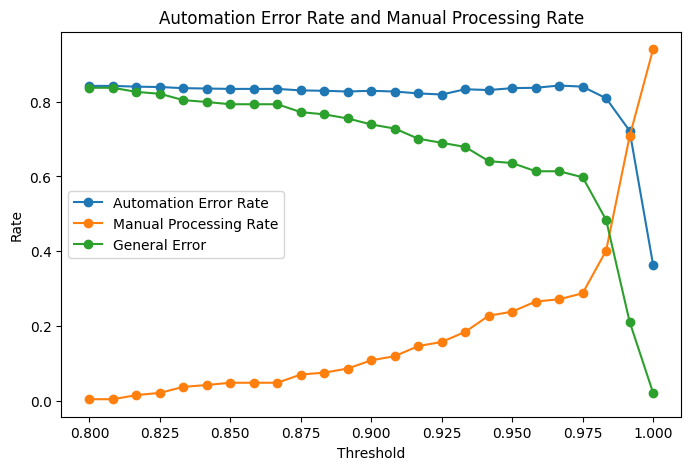

In [30]:
# Преобразование метрик в удобный формат для построения графика
auto_error_rate_values = [metrics["auto_error_rate"] for metrics in metrics_list]
manual_processing_rate_values = [
    metrics["manual_processing_rate"] for metrics in metrics_list
]
# general_spend_values = [metrics['general_spend'] for metrics in metrics_list]
general_error_values = [metrics["general_error"] for metrics in metrics_list]

# Определение общих границ для оси y
y_min = min(min(auto_error_rate_values), min(manual_processing_rate_values))
y_max = max(max(auto_error_rate_values), max(manual_processing_rate_values))

# Построение графика
plt.figure(figsize=(8, 5))

# plt.subplot(1, 2, 1)
plt.plot(
    threshold_values, auto_error_rate_values, marker="o", label="Automation Error Rate"
)
plt.plot(
    threshold_values,
    manual_processing_rate_values,
    marker="o",
    label="Manual Processing Rate",
)
plt.plot(threshold_values, general_error_values, marker="o", label="General Error")
plt.xlabel("Threshold")
plt.ylabel("Rate")
plt.title("Automation Error Rate and Manual Processing Rate")
plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(threshold_values, general_spend_values, marker='o', label='General Spend')
# plt.xlabel('Threshold')
# plt.ylabel('Money')
# plt.title('General Spend as Threshold')
# plt.legend()


# plt.tight_layout()
plt.show()

In [32]:
y_pred, manual_review = find_matches_rubert(
    x_vec, reference_id, reference_vec, top_k=5, threshold=0.875
)

metrics = mtc.calculate_metrics(y, y_pred, manual_review)
metrics

{'Accuracy@1': 0.17,
 'Accuracy@3': 0.251,
 'Accuracy@5': 0.304,
 'auto_error_rate': 0.83,
 'manual_processing_rate': 0.071,
 'general_error': 0.772}